# Setup

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s /content/drive/MyDrive/aml-assignments/assignment-2/ assignment-2

Mounted at /content/drive


# Imports


In [2]:
!pip install torchinfo

In [3]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchinfo import summary

In [5]:
# utility imports
import os
from tqdm import tqdm
import pickle

In [6]:
import warnings

warnings.filterwarnings("ignore")

# Configuration


In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
SAMPLE_SIZE = 16
NUM_FEATURES_GEN = 4
NUM_FEATURES_DISC = 2
NUM_CHANNELS = 1
Z_DIM = 16

EPOCHS = 10
GRAD_NORM_CLIP = 1
LEARNING_RATE = 2e-4
BETA = (0.5, 0.999)

In [8]:
def modelsummary(model, input_size):
    print(
        summary(
            model,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params"],
        )
    )

# Dataset


In [9]:
class MnistDataset(Dataset):
    def __init__(self, img_file: str, transform=None, device: str = DEVICE):
        super().__init__()
        self.images = pd.read_csv(img_file)
        self.labels = self.images["label"]
        self.images.drop(columns=["label"], inplace=True)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = torch.tensor(self.images.iloc[index, :]).view((1, 28, 28)).float() / 255
        img = (img * 2) - 1
        if self.transform:
            img = self.transform(img)
        img = img.to(self.device)
        return img, self.labels[index]

    def show(self, index):
        img = torch.tensor(self.images.loc[index, :]).view((28, 28)).float()
        label = self.labels[index]
        plt.imshow(img, cmap="gray")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f"Label: {label}")
        plt.tight_layout()
        plt.show()

In [10]:
data = MnistDataset("assignment-2/data/mnist/mnist_test.csv")

# GAN


## Generator


In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=200):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 7*7*128, bias=False),
            nn.BatchNorm1d(7*7*128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=2, output_padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2, padding=1, output_padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

model = Generator()
modelsummary(model, (BATCH_SIZE, 200))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Generator                                [32, 200]                 [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 200]                 [32, 1, 28, 28]           --
│    └─Linear: 2-1                       [32, 200]                 [32, 6272]                1,254,400
│    └─BatchNorm1d: 2-2                  [32, 6272]                [32, 6272]                12,544
│    └─LeakyReLU: 2-3                    [32, 6272]                [32, 6272]                --
│    └─Unflatten: 2-4                    [32, 6272]                [32, 128, 7, 7]           --
│    └─ConvTranspose2d: 2-5              [32, 128, 7, 7]           [32, 64, 7, 7]            204,800
│    └─BatchNorm2d: 2-6                  [32, 64, 7, 7]            [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-7                    [32, 64, 7, 7]            [32, 64, 7, 7]            --
│    └─ConvTranspo

## Discriminator


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = Discriminator()
modelsummary(model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Discriminator                            [32, 1, 28, 28]           [32, 1]                   --
├─Sequential: 1-1                        [32, 1, 28, 28]           [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 1, 28, 28]           [32, 64, 14, 14]          1,664
│    └─LeakyReLU: 2-2                    [32, 64, 14, 14]          [32, 64, 14, 14]          --
│    └─Dropout: 2-3                      [32, 64, 14, 14]          [32, 64, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 14, 14]          [32, 128, 7, 7]           204,928
│    └─LeakyReLU: 2-5                    [32, 128, 7, 7]           [32, 128, 7, 7]           --
│    └─Dropout: 2-6                      [32, 128, 7, 7]           [32, 128, 7, 7]           --
│    └─Flatten: 2-7                      [32, 128, 7, 7]           [32, 6272]                --
│    └─Linear: 2-8         

## Weights initialisation

initialising the weights to $\mathbb{N}(0, 0.02^2)$


In [13]:
def weights_initialisation(model):
    for m in model.modules():
        classname = m.__class__.__name__
        if (
            classname.find("Conv") != -1
            or classname.find("Linear") != -1
        ):
            nn.init.normal_(m.weight.data, 0.0, 0.2)

        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

# Training


In [14]:
def visualise(samples_per_epoch):
    samples = samples_per_epoch.cpu()
    fig, axs = plt.subplots(2, 8)
    rows = [samples[:8], samples[8:]]
    for i, ax in enumerate(axs):
        for j, a in enumerate(ax):
            a.imshow(rows[i][j].view(28, 28).data)
            a.set_xticks([], [])
            a.set_yticks([], [])
    plt.tight_layout()
    plt.show()

In [15]:
def train_one_epoch(
    epoch, gen, disc, train_dataloader, optimiser_gen, optimiser_disc, loss_fn
):
    loop = tqdm(train_dataloader, unit=" batch")
    losses = []
    for i, (real, _) in enumerate(loop):
        loop.set_description_str(f"Epoch = {epoch}")

        # forward pass
        real = real.to(DEVICE)
        noise = (
            torch.distributions.uniform.Uniform(-1, 1)
            .sample([BATCH_SIZE, 200])
            .to(DEVICE)
        )
        fake = gen(noise)

        # train discriminator
        disc_out_real = disc(real).reshape(-1)
        loss_disc_real = loss_fn(disc_out_real, torch.ones_like(disc_out_real))

        disc_out_fake = disc(fake).reshape(-1)
        loss_disc_fake = loss_fn(disc_out_fake, torch.zeros_like(disc_out_fake))

        loss_disc = (loss_disc_fake + loss_disc_real) / 2
        optimiser_disc.zero_grad(set_to_none=True)
        loss_disc.backward(retain_graph=True)
        optimiser_disc.step()

        # train generator
        out = disc(fake).reshape(-1)
        loss_gen = loss_fn(out, torch.ones_like(out))
        optimiser_gen.zero_grad(set_to_none=True)
        loss_gen.backward()
        optimiser_gen.step()

        losses.append([loss_disc.cpu().item(), loss_gen.cpu().item()])

        if i % 10 == 0:
            loop.set_postfix_str(
                f"Discriminator Loss = {loss_disc.item(): .3f} | Generator Loss = {loss_gen.item(): .3f}"
            )
    return losses


def train(
    gen,
    disc,
    train_dataloader,
    optimiser_gen,
    optimiser_disc,
    loss_fn,
    fixed_z,
):
    samples = []
    losses = []
    for epoch in range(EPOCHS):
        model.train()
        losses_per_epoch = train_one_epoch(
            epoch + 1,
            gen,
            disc,
            train_dataloader,
            optimiser_gen,
            optimiser_disc,
            loss_fn,
        )

        gen.eval()
        samples_per_epoch = generate(gen, fixed_z)

        visualise(samples_per_epoch)

        samples.append(samples_per_epoch)
        losses.extend(losses_per_epoch)

    with open("assignment-2/saved-model/train_samples.pkl", "wb") as f:
        pickle.dump(samples, f)


def generate(gen, fixed_z):
    return gen(fixed_z)

In [19]:
def save_model(model, name):
    torch.save(model.state_dict(), f"assignment-2/saved-model/gan-{name}.pth")


def load_model(model, name):
    model.load_state_dict(torch.load(f"assignment-2/saved-model/gan-{name}.pth"))


def train_network(
    gen: nn.Module,
    disc: nn.Module,
    train_dataloader: DataLoader,
    name: str,
):
    weights_initialisation(gen)
    weights_initialisation(disc)
    optimiser_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=BETA)
    optimiser_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=BETA)
    loss_fn = nn.BCELoss()
    fixed_z = (
        torch.distributions.uniform.Uniform(-1, 1)
        .sample([SAMPLE_SIZE, 200])
        .to(DEVICE)
    )

    losses = train(
        gen,
        disc,
        train_dataloader,
        optimiser_gen,
        optimiser_disc,
        loss_fn,
        fixed_z,
    )
    save_model(gen, "gan-gen-trail-2-50-epochs")
    save_model(disc, "gan-disc-trail-2-50-epochs")
    return losses

In [17]:
train_dataset = MnistDataset("assignment-2/data/mnist/mnist_train.csv")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch = 1: 100%|██████████| 1875/1875 [02:51<00:00, 10.94 batch/s, Discriminator Loss =  10.015 | Generator Loss =  39.508]


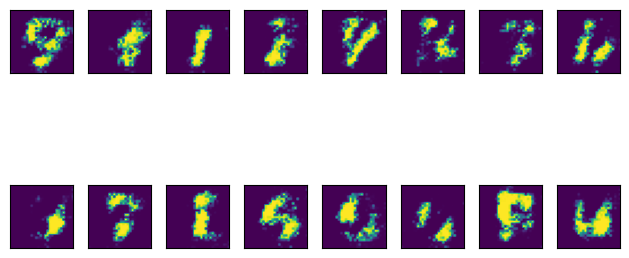

Epoch = 2: 100%|██████████| 1875/1875 [02:51<00:00, 10.94 batch/s, Discriminator Loss =  7.489 | Generator Loss =  15.005]


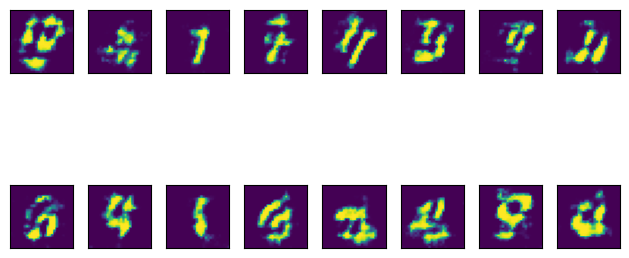

Epoch = 3: 100%|██████████| 1875/1875 [02:51<00:00, 10.94 batch/s, Discriminator Loss =  3.218 | Generator Loss =  10.250]


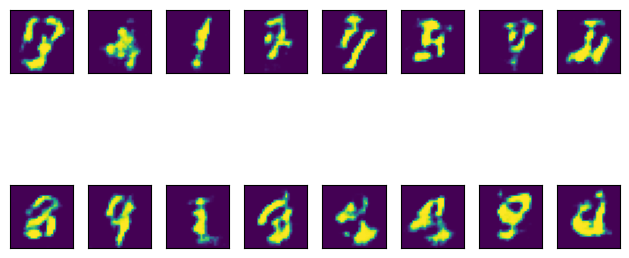

Epoch = 4: 100%|██████████| 1875/1875 [02:54<00:00, 10.73 batch/s, Discriminator Loss =  1.419 | Generator Loss =  5.051]


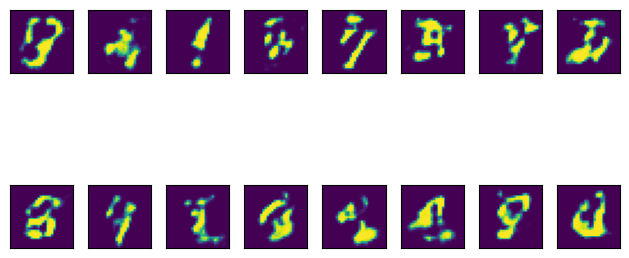

Epoch = 5: 100%|██████████| 1875/1875 [02:52<00:00, 10.84 batch/s, Discriminator Loss =  2.934 | Generator Loss =  8.466]


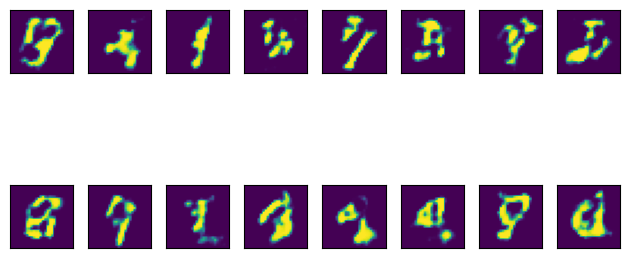

Epoch = 6: 100%|██████████| 1875/1875 [02:53<00:00, 10.82 batch/s, Discriminator Loss =  0.756 | Generator Loss =  7.425]


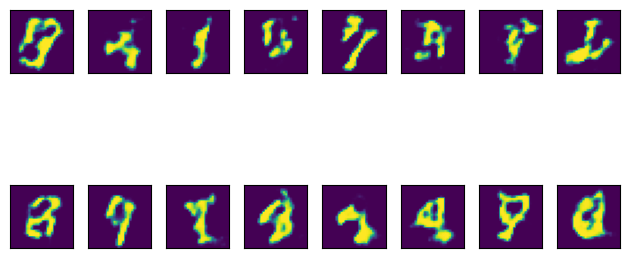

Epoch = 7: 100%|██████████| 1875/1875 [02:55<00:00, 10.67 batch/s, Discriminator Loss =  0.579 | Generator Loss =  7.433]


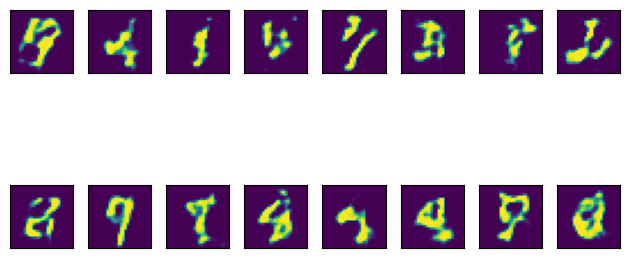

Epoch = 8: 100%|██████████| 1875/1875 [02:55<00:00, 10.71 batch/s, Discriminator Loss =  1.143 | Generator Loss =  5.279]


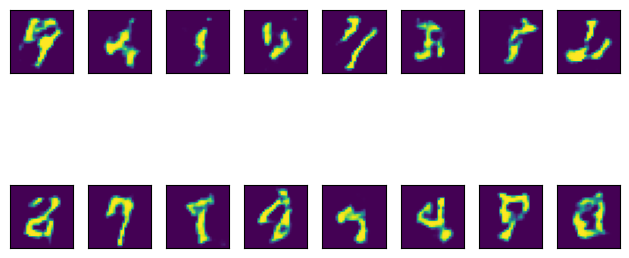

Epoch = 9: 100%|██████████| 1875/1875 [02:55<00:00, 10.69 batch/s, Discriminator Loss =  0.786 | Generator Loss =  3.336]


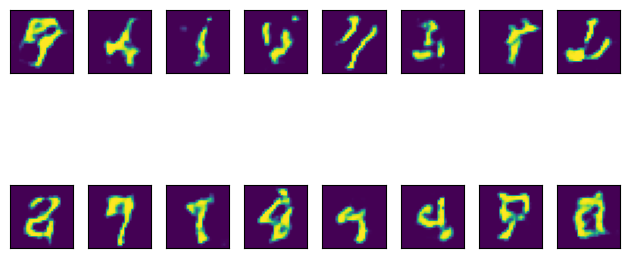

Epoch = 10: 100%|██████████| 1875/1875 [02:55<00:00, 10.70 batch/s, Discriminator Loss =  0.833 | Generator Loss =  3.661]


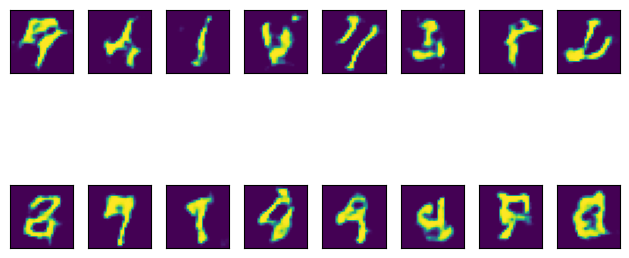

In [18]:
disc = Discriminator().to(DEVICE)
gen = Generator().to(DEVICE)
train_network(gen, disc, train_dataloader, "trial-1")

Epoch = 1: 100%|██████████| 1875/1875 [02:50<00:00, 11.02 batch/s, Discriminator Loss =  3.301 | Generator Loss =  39.650]


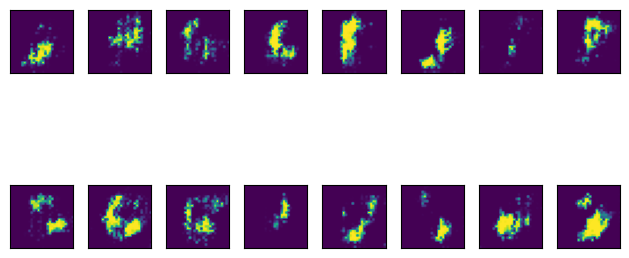

Epoch = 2: 100%|██████████| 1875/1875 [02:47<00:00, 11.17 batch/s, Discriminator Loss =  4.001 | Generator Loss =  17.249]


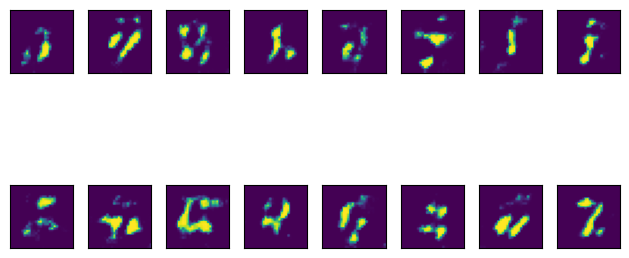

Epoch = 3: 100%|██████████| 1875/1875 [02:48<00:00, 11.11 batch/s, Discriminator Loss =  1.057 | Generator Loss =  10.788]


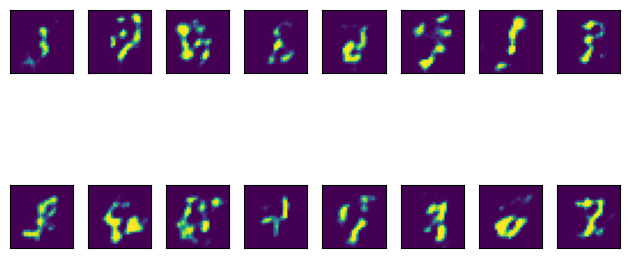

Epoch = 4: 100%|██████████| 1875/1875 [02:50<00:00, 11.01 batch/s, Discriminator Loss =  2.127 | Generator Loss =  8.306]


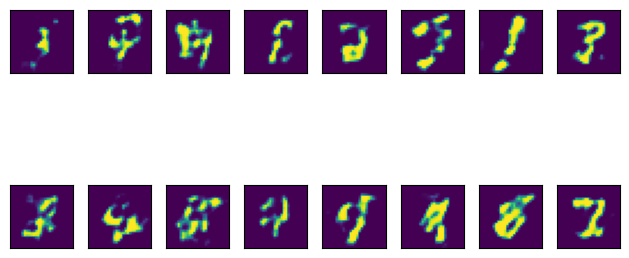

Epoch = 5: 100%|██████████| 1875/1875 [02:52<00:00, 10.90 batch/s, Discriminator Loss =  3.100 | Generator Loss =  7.412]


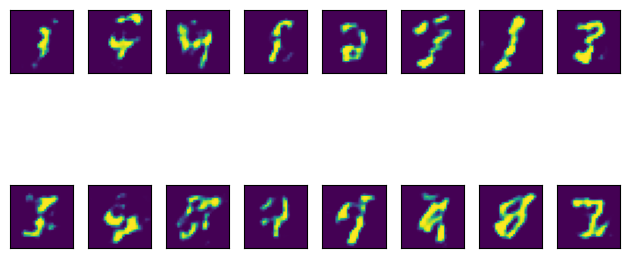

Epoch = 6: 100%|██████████| 1875/1875 [02:51<00:00, 10.92 batch/s, Discriminator Loss =  0.814 | Generator Loss =  5.293]


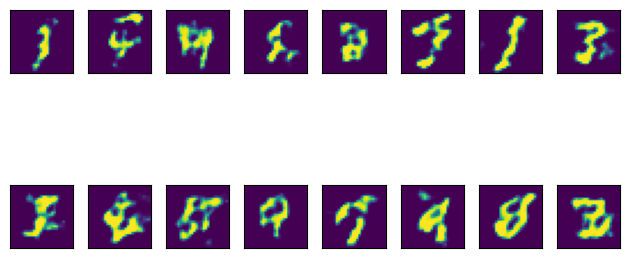

Epoch = 7: 100%|██████████| 1875/1875 [02:52<00:00, 10.90 batch/s, Discriminator Loss =  1.220 | Generator Loss =  6.337]


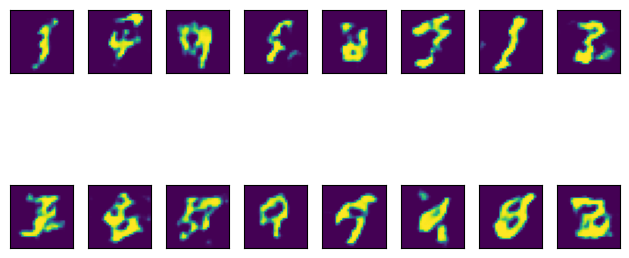

Epoch = 8: 100%|██████████| 1875/1875 [02:52<00:00, 10.86 batch/s, Discriminator Loss =  0.885 | Generator Loss =  5.558]


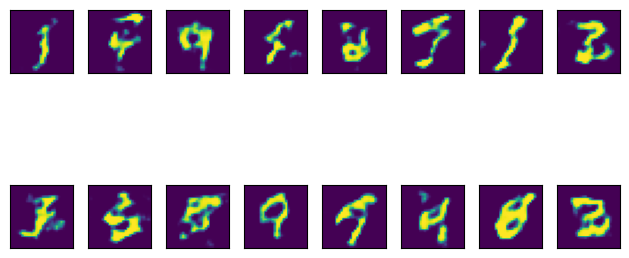

Epoch = 9: 100%|██████████| 1875/1875 [02:53<00:00, 10.79 batch/s, Discriminator Loss =  0.544 | Generator Loss =  5.041]


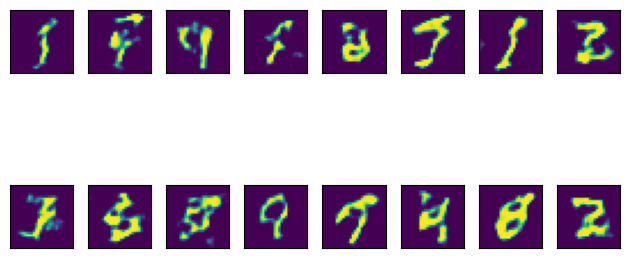

Epoch = 10: 100%|██████████| 1875/1875 [02:54<00:00, 10.74 batch/s, Discriminator Loss =  0.530 | Generator Loss =  4.243]


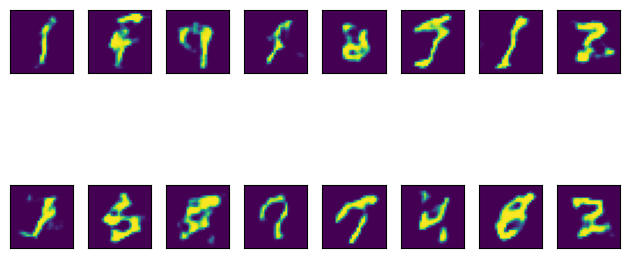

Epoch = 11: 100%|██████████| 1875/1875 [02:58<00:00, 10.52 batch/s, Discriminator Loss =  0.796 | Generator Loss =  4.115]


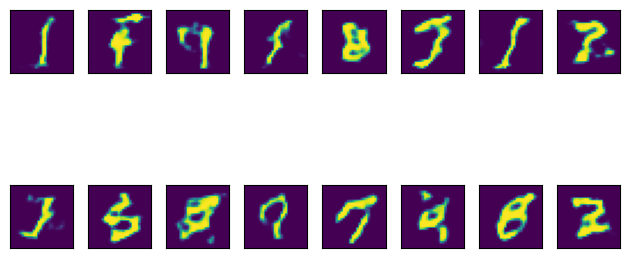

Epoch = 12: 100%|██████████| 1875/1875 [02:57<00:00, 10.58 batch/s, Discriminator Loss =  0.752 | Generator Loss =  2.257]


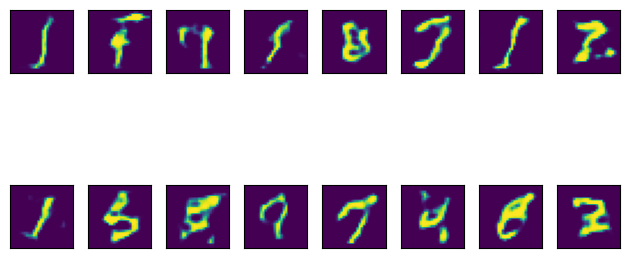

Epoch = 13: 100%|██████████| 1875/1875 [02:55<00:00, 10.65 batch/s, Discriminator Loss =  0.691 | Generator Loss =  2.674]


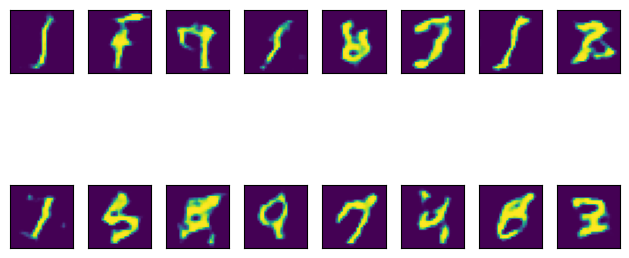

Epoch = 14: 100%|██████████| 1875/1875 [02:56<00:00, 10.63 batch/s, Discriminator Loss =  0.702 | Generator Loss =  2.322]


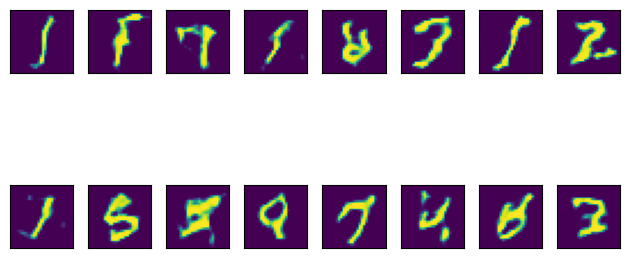

Epoch = 15: 100%|██████████| 1875/1875 [02:58<00:00, 10.49 batch/s, Discriminator Loss =  0.481 | Generator Loss =  2.514]


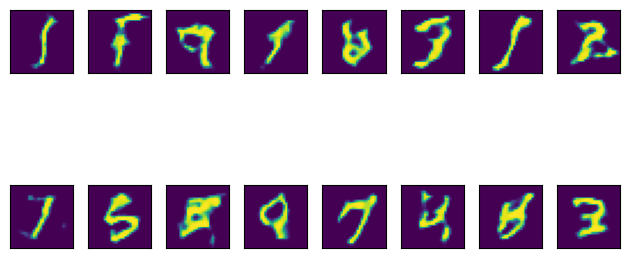

Epoch = 16: 100%|██████████| 1875/1875 [02:57<00:00, 10.55 batch/s, Discriminator Loss =  0.659 | Generator Loss =  2.298]


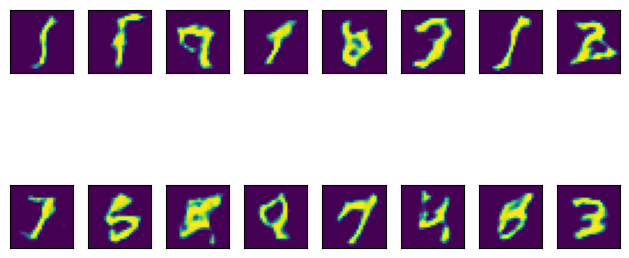

Epoch = 17: 100%|██████████| 1875/1875 [03:00<00:00, 10.38 batch/s, Discriminator Loss =  0.570 | Generator Loss =  1.923]


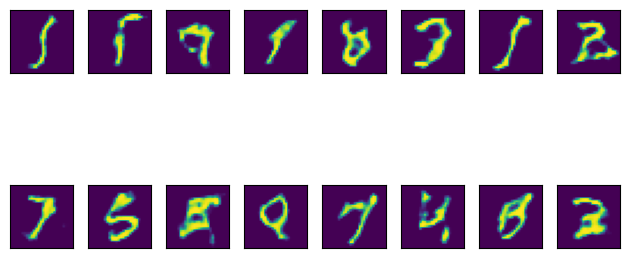

Epoch = 18: 100%|██████████| 1875/1875 [02:59<00:00, 10.42 batch/s, Discriminator Loss =  0.531 | Generator Loss =  1.767]


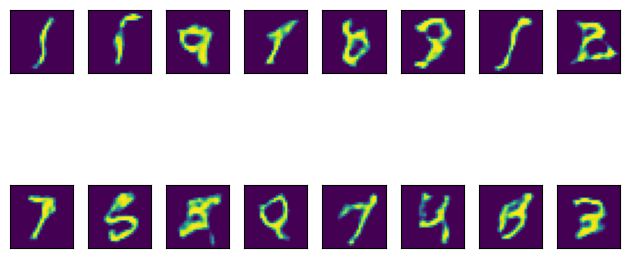

Epoch = 19: 100%|██████████| 1875/1875 [02:59<00:00, 10.47 batch/s, Discriminator Loss =  0.502 | Generator Loss =  1.677]


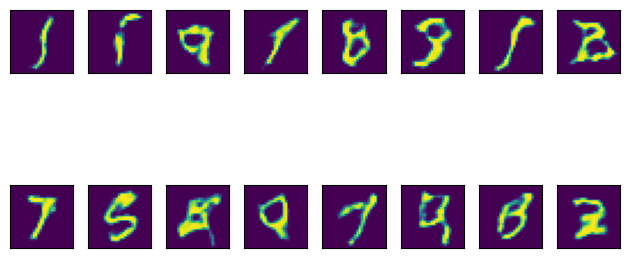

Epoch = 20: 100%|██████████| 1875/1875 [03:02<00:00, 10.30 batch/s, Discriminator Loss =  0.340 | Generator Loss =  2.036]


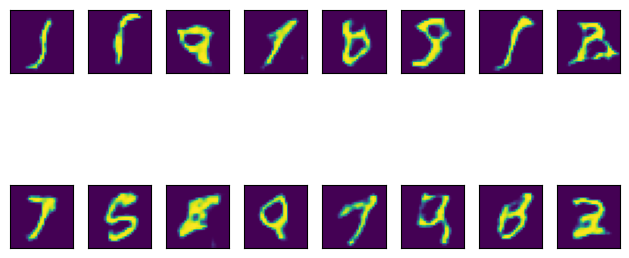

Epoch = 21: 100%|██████████| 1875/1875 [03:01<00:00, 10.36 batch/s, Discriminator Loss =  0.527 | Generator Loss =  1.811]


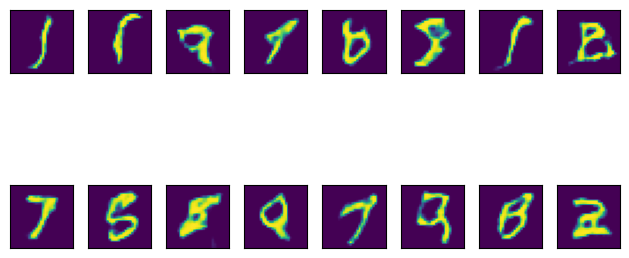

Epoch = 22: 100%|██████████| 1875/1875 [03:03<00:00, 10.23 batch/s, Discriminator Loss =  0.529 | Generator Loss =  1.263]


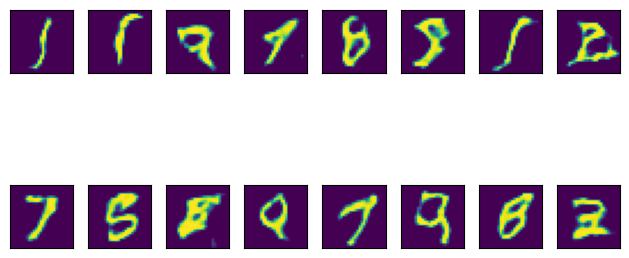

Epoch = 23: 100%|██████████| 1875/1875 [03:03<00:00, 10.22 batch/s, Discriminator Loss =  0.617 | Generator Loss =  1.972]


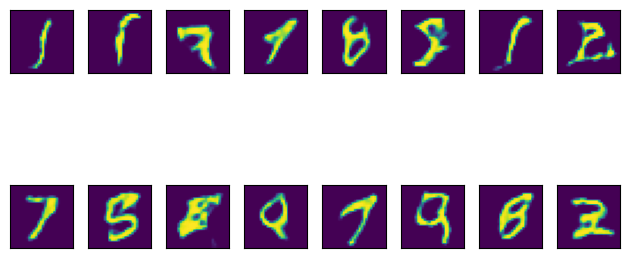

Epoch = 24: 100%|██████████| 1875/1875 [03:07<00:00, 10.02 batch/s, Discriminator Loss =  0.506 | Generator Loss =  1.711]


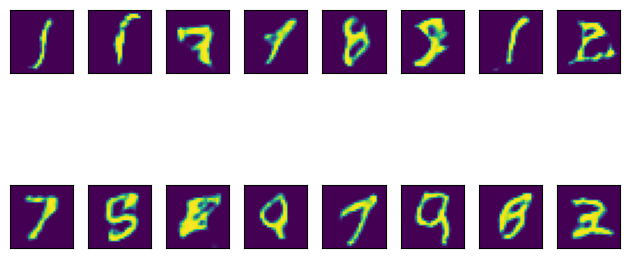

Epoch = 25: 100%|██████████| 1875/1875 [03:05<00:00, 10.09 batch/s, Discriminator Loss =  0.433 | Generator Loss =  1.332]


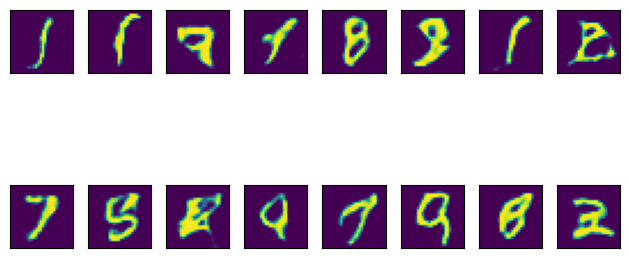

Epoch = 26: 100%|██████████| 1875/1875 [03:09<00:00,  9.90 batch/s, Discriminator Loss =  0.365 | Generator Loss =  1.712]


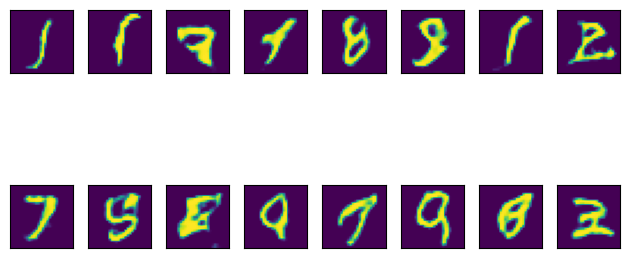

Epoch = 27: 100%|██████████| 1875/1875 [03:09<00:00,  9.90 batch/s, Discriminator Loss =  0.290 | Generator Loss =  1.684]


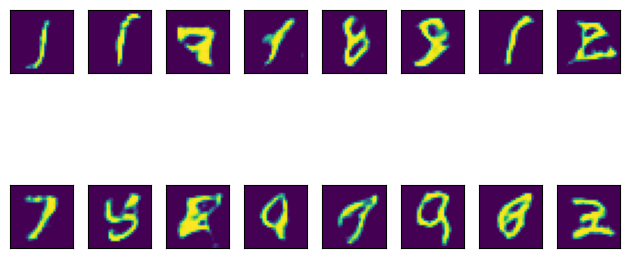

Epoch = 28: 100%|██████████| 1875/1875 [03:11<00:00,  9.81 batch/s, Discriminator Loss =  0.408 | Generator Loss =  1.500]


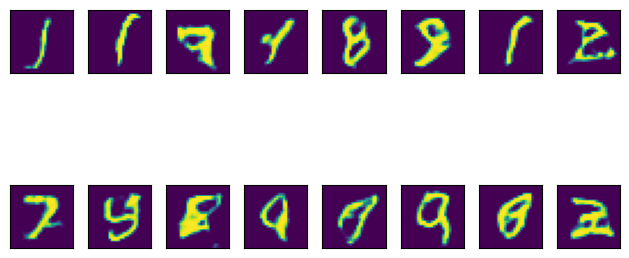

Epoch = 29: 100%|██████████| 1875/1875 [03:12<00:00,  9.73 batch/s, Discriminator Loss =  0.437 | Generator Loss =  1.578]


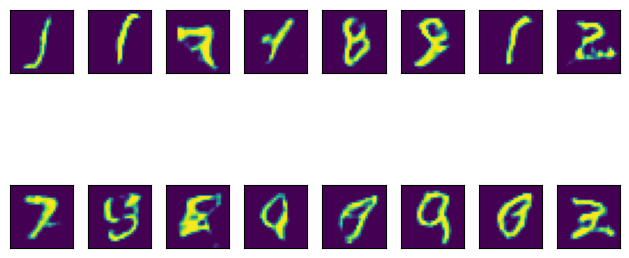

Epoch = 30: 100%|██████████| 1875/1875 [03:14<00:00,  9.65 batch/s, Discriminator Loss =  0.532 | Generator Loss =  1.447]


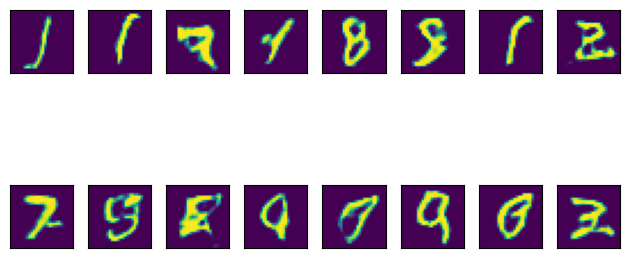

Epoch = 31: 100%|██████████| 1875/1875 [03:12<00:00,  9.74 batch/s, Discriminator Loss =  0.521 | Generator Loss =  1.950]


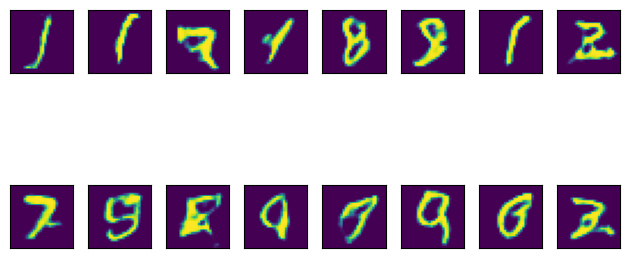

Epoch = 32: 100%|██████████| 1875/1875 [03:15<00:00,  9.59 batch/s, Discriminator Loss =  0.498 | Generator Loss =  1.760]


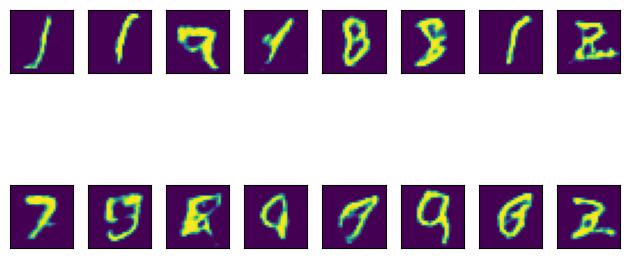

Epoch = 33: 100%|██████████| 1875/1875 [03:16<00:00,  9.53 batch/s, Discriminator Loss =  0.526 | Generator Loss =  1.829]


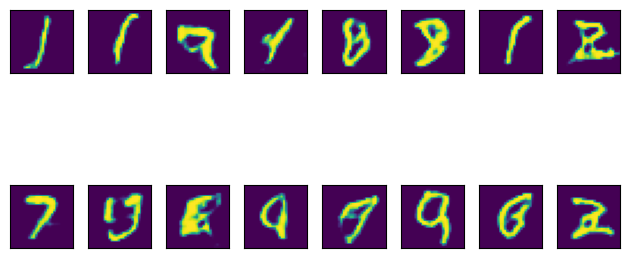

Epoch = 34: 100%|██████████| 1875/1875 [03:18<00:00,  9.47 batch/s, Discriminator Loss =  0.448 | Generator Loss =  1.745]


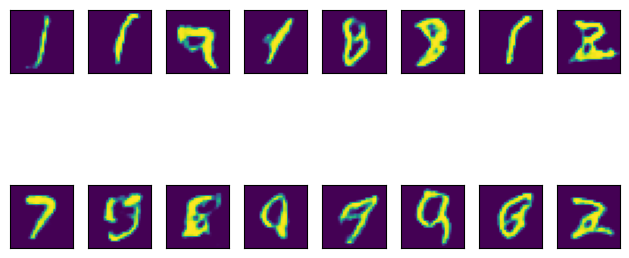

Epoch = 35:  37%|███▋      | 702/1875 [01:15<02:05,  9.35 batch/s, Discriminator Loss =  0.574 | Generator Loss =  1.889]


KeyboardInterrupt: ignored

In [21]:
EPOCHS = 50
disc = Discriminator().to(DEVICE)
gen = Generator().to(DEVICE)
train_network(gen, disc, train_dataloader, "trial-2-50-epochs")

Execution has been stopped as the images have more or less stabilised after 34 epochs, and both losses are not decreasing any further.